In [137]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
from torchvision.utils import save_image

# PARAMETERS

In [132]:
BATCH_SIZE = 100
EPOCHS = 5

# IMPORTING DATA

### MNIST

- Each img: (1,28,28)
- Training: 60,000
- Testing: 10,000


### CIFAR10

- Each img: (3,32,32)
- Training: 50, 000
- Testing: 10,000

In [31]:
mnist_training = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(),
    download=True,
)

mnist_testing = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
)

datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

cifar10_training = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = ToTensor(),
    download=True,
)

cifar10_testing = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = ToTensor(), 
)

Files already downloaded and verified


In [32]:
# Data Loaders

mnist_data_loader = {
    'train' : DataLoader(mnist_training, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
    'test'  : DataLoader(mnist_testing, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
}

cifar10_data_loader = {
    'train' : DataLoader(cifar10_training, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
    'test'  : DataLoader(cifar10_testing, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
}

# HELPER FUNCTIONS

In [45]:
def displayMNIST(dataset, index, save=False, title="Title"):
    
    display_img = dataset.data[index]
    display_lab = dataset.targets[index].numpy()
    
    fig, ax = plt.subplots(1)
    ax.imshow(display_img, cmap='gray')
    ax.text(2,2, 'Label='+str(display_lab), bbox={'facecolor': 'white', 'pad': 2}, fontsize=12)
    plt.axis('off')
    
    if save: plt.savefig(title+'.png')

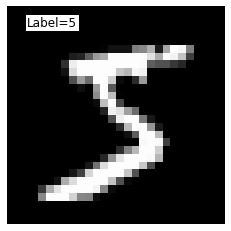

In [46]:
displayMNIST(mnist_training, 0)

In [47]:
def decodeCIFARLabel(target):
    
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'][target]

In [51]:
def displayCIFAR10(dataset, index, save=False, title="Title"):
    
    display_img = dataset.data[index]
    display_lab = dataset.targets[index]
    
    fig, ax = plt.subplots(1)
    ax.imshow(display_img, cmap='gray', interpolation='nearest')
    ax.text(2,2, 'Label='+str(display_lab)+" ("+decodeCIFARLabel(display_lab)+")", bbox={'facecolor': 'white', 'pad': 2}, fontsize=12)
    plt.axis('off')
    
    if save: plt.savefig(title+'.png')

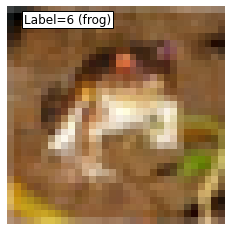

In [52]:
displayCIFAR10(cifar10_training, 0)

# VAE

In [175]:
# Reference: https://github.com/lyeoni/pytorch-mnist-VAE

class VAE2(nn.Module):
    def __init__(self, img_dim, latent_size):
        
        super(VAE2, self).__init__()
        
        x_dim = img_dim * img_dim
        h_dim1 = 512
        h_dim2 = 256
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, latent_size)
        self.fc32 = nn.Linear(h_dim2, latent_size)
        
        # decoder part
        self.fc4 = nn.Linear(latent_size, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        x_dim = x.shape[2] ** 2
        mu, log_var = self.encoder(x.view(-1, x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
    
#vae2_latent2 = VAE2(latent_size=2)
#summary(vae2_latent2, (1,28,28))

In [176]:
# Reference: https://github.com/lyeoni/pytorch-mnist-VAE

class VAE3(nn.Module):
    def __init__(self, img_dim, latent_size):
        
        super(VAE3, self).__init__()
        
        x_dim = img_dim * img_dim
        h_dim1 = 1024
        h_dim2 = 512
        h_dim3 = 256
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc41 = nn.Linear(h_dim3, latent_size)
        self.fc42 = nn.Linear(h_dim3, latent_size)
        
        # decoder part
        self.fc5 = nn.Linear(latent_size, h_dim3)
        self.fc6 = nn.Linear(h_dim3, h_dim2)
        self.fc7 = nn.Linear(h_dim2, h_dim1)
        self.fc8 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc41(h), self.fc42(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        return torch.sigmoid(self.fc8(h)) 
    
    def forward(self, x):
        x_dim = x.shape[2] ** 2
        mu, log_var = self.encoder(x.view(-1, x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
    
#vae3_latent5 = VAE3(img_dim=32, latent_size=5)
#summary(vae3_latent5, (3,32,32))

In [177]:
# Reference: https://github.com/lyeoni/pytorch-mnist-VAE

class VAE4(nn.Module):
    def __init__(self, img_dim, latent_size):
        
        super(VAE4, self).__init__()
        
        x_dim = img_dim * img_dim
        h_dim1 = 2048
        h_dim2 = 1024
        h_dim3 = 512
        h_dim4 = 256
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc4 = nn.Linear(h_dim3, h_dim4)
        self.fc51 = nn.Linear(h_dim4, latent_size)
        self.fc52 = nn.Linear(h_dim4, latent_size)
        
        # decoder part
        self.fc5 = nn.Linear(latent_size, h_dim4)
        self.fc6 = nn.Linear(h_dim4, h_dim3)
        self.fc7 = nn.Linear(h_dim3, h_dim2)
        self.fc8 = nn.Linear(h_dim2, h_dim1)
        self.fc9 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return self.fc51(h), self.fc52(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        h = F.relu(self.fc8(h))
        return torch.sigmoid(self.fc9(h)) 
    
    def forward(self, x):
        x_dim = x.shape[2] ** 2
        mu, log_var = self.encoder(x.view(-1, x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

#vae4_latent10 = VAE4(latent_size=10)
#summary(vae4_latent10, (1,28,28))

# Experiment

In [180]:
def TRAIN_VAE(total_epochs, vae, optimizer, data_loader):
    
    print("_________________________________________________________________ TRAINING")
    
    train_loader = data_loader['train']
    test_loader = data_loader['test']
    
    for epoch in range(total_epochs):
        print("_________________________________")
        training_iteration(epoch+1, vae, train_loader, optimizer)
        test(vae, test_loader)
    
def training_iteration(epoch, vae, train_loader, optimizer):
    vae.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
def test(vae, test_loader):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
def loss_function(recon_x, x, mu, log_var):
    x_dim = x.shape[2] ** 2
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [189]:
def save_Sample(vae, img_dim, latent_size, title):
    with torch.no_grad():
        z = torch.randn(64, latent_size)
        sample = vae.decoder(z)

        save_image(sample.view(64, 1, img_dim, img_dim), 'output/' +title+ '.png')

In [135]:
vae2_latent2 = VAE2(img_dim = 28, latent_size=2)
optimizer2_latent2 = optim.Adam(vae2_latent2.parameters())
summary(vae2_latent2, (1,28,28))

TRAIN_VAE(EPOCHS, vae2_latent2, optimizer2_latent2, mnist_data_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                    [-1, 2]             514
            Linear-4                    [-1, 2]             514
            Linear-5                  [-1, 256]             768
            Linear-6                  [-1, 512]         131,584
            Linear-7                  [-1, 784]         402,192
Total params: 1,068,820
Trainable params: 1,068,820
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 4.08
Estimated Total Size (MB): 4.10
----------------------------------------------------------------
_________________________________________________________________ TRAINING
___________________________

In [191]:
save_Sample(vae2_latent2, img_dim=28, latent_size=2, title='mnist_2_2_sample')

In [181]:
vae2_latent5 = VAE2(img_dim = 32, latent_size=5)
optimizer2_latent5 = optim.Adam(vae2_latent5.parameters())
summary(vae2_latent5, (3,32,32))

TRAIN_VAE(EPOCHS, vae2_latent5, optimizer2_latent5, cifar10_data_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         524,800
            Linear-2                  [-1, 256]         131,328
            Linear-3                    [-1, 5]           1,285
            Linear-4                    [-1, 5]           1,285
            Linear-5                  [-1, 256]           1,536
            Linear-6                  [-1, 512]         131,584
            Linear-7                 [-1, 1024]         525,312
Total params: 1,317,130
Trainable params: 1,317,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 5.02
Estimated Total Size (MB): 5.06
----------------------------------------------------------------
_________________________________________________________________ TRAINING
___________________________

In [192]:
save_Sample(vae2_latent5, img_dim=32, latent_size=5, title='cifar10_2_5_sample')

In [193]:
vae4_latent2 = VAE4(img_dim = 32, latent_size=2)
optimizer4_latent2 = optim.Adam(vae4_latent2.parameters())
summary(vae4_latent2, (3,32,32))

EPOCHS=100
TRAIN_VAE(EPOCHS, vae4_latent2, optimizer4_latent2, cifar10_data_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       2,099,200
            Linear-2                 [-1, 1024]       2,098,176
            Linear-3                  [-1, 512]         524,800
            Linear-4                  [-1, 256]         131,328
            Linear-5                    [-1, 2]             514
            Linear-6                    [-1, 2]             514
            Linear-7                  [-1, 256]             768
            Linear-8                  [-1, 512]         131,584
            Linear-9                 [-1, 1024]         525,312
           Linear-10                 [-1, 2048]       2,099,200
           Linear-11                 [-1, 1024]       2,098,176
Total params: 9,709,572
Trainable params: 9,709,572
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

KeyboardInterrupt: 

In [ ]:
save_Sample(vae4_latent2, img_dim=32, latent_size=2, title='cifar10_4_2_sample')